# Прогнозирование заказов такси 🚕

**Описание проекта:** Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Содержание**<a id='toc0_'></a> 

1. [Подготовка данных](#toc1_)                                  
  1.1 [Установка библиотек и конфигурации](#toc1_1_)    
  1.2 [Функции, используемые в проекте](#toc1_2_)                                                              
 
2. [Анализ данных](#toc2_)         
                      
3. [Обучение моделей](#toc3_)                                                     
  3.1 [LinearRegression](#toc3_1_)    
  3.2 [RandomForestRegressor](#toc3_2_)                                                            
  3.3 [LGBMRegressor](#toc3_3_)                                                            

4. [Тестирование](#toc4_)                                             
  
5. [Вывод](#toc5_)



## <a id='toc1_'></a> 1. Подготовка данных[&#8593;](#toc0_)

### <a id='toc1_1_'></a> 1.1 Установка библиотек  и конфигурации [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [2]:
from platform import python_version
version = python_version()

if version.startswith('3.9'):  
    pass
    %pip install --force-reinstall -v "numpy==1.22.4" -q
else: 
    pass
    %pip install --upgrade numpy -q   

%pip install --force-reinstall -v "matplotlib==3.8.0" -q

%pip install --upgrade phik -q
%pip install --upgrade prettytable -q
%pip install --upgrade termcolor -q
%pip install --upgrade seaborn -q
%pip install --upgrade pandas -q
%pip install --upgrade statsmodels -q
%pip install --upgrade scikit-learn -q
%pip install --upgrade shap -q
%pip install --upgrade imbalanced-learn -q
%pip install --upgrade optuna -q

clear_output()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import re


from os.path import exists

# preprocessing
from sklearn.model_selection import (
    GridSearchCV,                                 
    train_test_split)
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder)
from sklearn.impute import (
    SimpleImputer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
# metrics
from sklearn.metrics import root_mean_squared_error

# additional tools
from phik import phik_matrix 
from prettytable import PrettyTable
from termcolor import colored
from sklearn.inspection import permutation_importance

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)

### <a id='toc1_2_'></a> 1.2 Функции, используемые в проекте [&#8593;](#toc0_)

In [5]:
def get_dataframe(paths: list[str]) -> pd.DataFrame:
    for _path in paths:
        if not exists(_path) and not _path.startswith('http'):
            continue
        
        try:
            df = pd.read_csv(_path)
        except:
            continue
        
        if df is None:
            continue
        
        return df
    
    raise FileNotFoundError('No paths are valid and/or for correct csv file.')

In [6]:
def print_nans_table(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Признаки', 'Пропущенное количество значений']
    
    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'blue' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.1%})'
        table.add_row([col, colored(s, color)])
    
    print(table)

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    data_n = data.copy()
    data_n['year'] = data_n.index.year
    data_n['month'] = data_n.index.month
    data_n['day'] = data_n.index.day
    data_n['dayofweek'] = data_n.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_n['lag_{}'.format(lag)] = data_n['num_orders'].shift(lag)
    data_n['rolling_mean'] = data_n['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_n

## <a id='toc2_'></a> 2. Анализ данных[&#8593;](#toc0_)

 1. Загрузка данных 

In [8]:
df = get_dataframe(['/datasets/taxi.csv'])

In [9]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


2. Посмотрим информацию о типах данных и пропусках

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [11]:
print_nans_table(df)

+------------+---------------------------------+
|  Признаки  | Пропущенное количество значений |
+------------+---------------------------------+
|  datetime  |             0 (0.0%)            |
| num_orders |             0 (0.0%)            |
+------------+---------------------------------+


3. Поменяем тип данных datetime:

In [12]:
df['datetime'] = df['datetime'].astype('datetime64[ns]')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


4. Установим дату в качестве индекса:

In [14]:
df = df.set_index('datetime')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [16]:
df = df.sort_index()

In [17]:
df.index.is_monotonic_increasing

True

4. Построим график ряда:

<Axes: xlabel='datetime'>

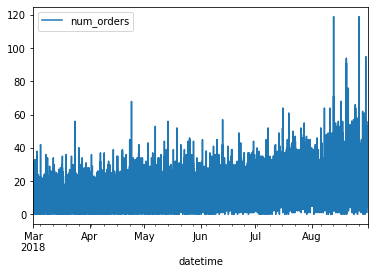

In [18]:
df.plot()

5. Ресемплируем ряд по часам:

<Axes: xlabel='datetime'>

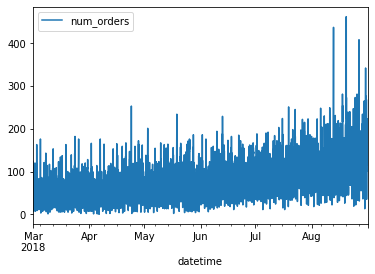

In [19]:
df.sort_index(inplace=True)
df =  df.resample('1h').sum()
df.plot()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Уменьшили количество строк более чем в 6 раз и теперь на графике видим восходящий тренд к концу лета 2018

6. Разложим ряд на тренд и сезонную компоненту


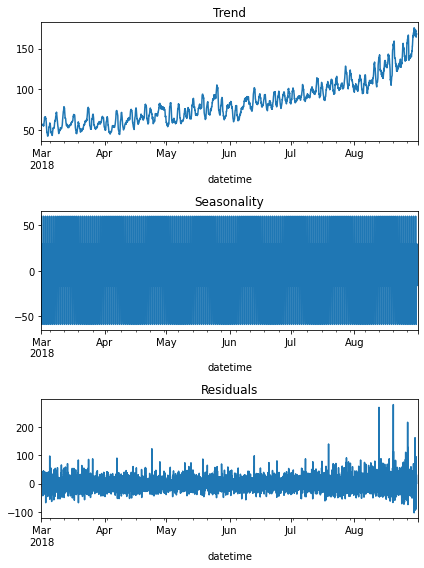

In [21]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<Axes: xlabel='datetime'>

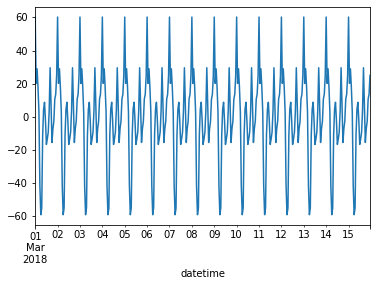

In [22]:
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())

Тренд восходящий, в чем мы еще раз убедились. Сезонность определяется сутками. Про остатки ничего нельзя сказать

7. Посмотрим на распределение остатков и их медианного и среднего значений.

<Axes: xlabel='datetime'>

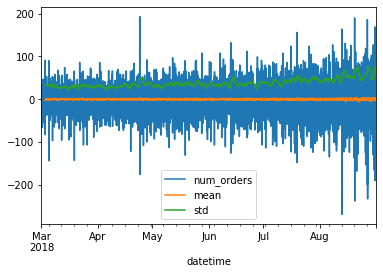

In [23]:
df1 = df - df.shift()# < напишите код здесь >
df1['mean'] = df1['num_orders'].rolling(50).mean()
df1['std'] = df1['num_orders'].rolling(50).std()
df1.plot()

Ряд вполне готов к прогнозированию в виду близости к стационарному. Среднее в std так же близко к нулевому тренду визуально.

## <a id='toc3_'></a> 3. Обучение моделей[&#8593;](#toc0_)

### <a id='toc3_1_'></a> 3.1 LinearRegression [&#8593;](#toc0_)

In [24]:
df_lr = df.copy()

In [25]:
df_lr = make_features(df_lr, 24, 10)

In [26]:
df_lr.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.00,124.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.00,85.00,124.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.00,71.00,85.00,124.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_lr.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.00,124.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.00,85.00,124.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.00,71.00,85.00,124.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
train_lr, test_lr = train_test_split(df_lr, shuffle=False, test_size=0.1)
train_lr = train_lr.dropna()
X_train_lr = train_lr.drop(columns='lag_1')
y_train_lr = train_lr['lag_1']
X_test_lr = test_lr.drop(columns='lag_1')
y_test_lr = test_lr['lag_1']

In [29]:
model = LinearRegression(n_jobs=-1) 

model.fit(X_train_lr, y_train_lr)

root_mean_squared_error(y_train_lr, model.predict(X_train_lr))


2.7626310865889394e-13

### <a id='toc3_2_'></a> 3.2 RandomForestRegressor [&#8593;](#toc0_)

In [30]:
df_rfr = df.copy()

In [31]:
df_rfr = make_features(df_rfr, 24, 10)

In [32]:
df_rfr.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.00,124.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.00,85.00,124.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.00,71.00,85.00,124.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
train_rfr, test_rfr = train_test_split(df_rfr, shuffle=False, test_size=0.1)
train_rfr = train_rfr.dropna()
X_train_rfr = train_rfr.drop(columns='lag_1')
y_train_rfr = train_rfr['lag_1']
X_test_rfr = test_rfr.drop(columns='lag_1')
y_test_rfr = test_rfr['lag_1']

In [34]:
final_pipe_rfr = Pipeline(
    [
        ('model', RandomForestRegressor(
        random_state=RANDOM_STATE, n_jobs=-1))
    ]
)

In [35]:
param_grid_rfr = {
    'model__n_estimators': [100, 500, 1000],
    'model__min_samples_split': range(2, 5),
    'model__min_samples_leaf': range(2, 5)
}

In [36]:
grid_rfr = GridSearchCV(
    final_pipe_rfr,
    param_grid=param_grid_rfr,
    cv=TimeSeriesSplit(),
    scoring= 'neg_root_mean_squared_error'
)

In [37]:
%%time
grid_rfr.fit(X_train_rfr, y_train_rfr)

CPU times: user 32min 46s, sys: 4.82 s, total: 32min 51s
Wall time: 32min 53s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             param_grid={'model__min_samples_leaf': range(2, 5),
                         'model__min_samples_split': range(2, 5),
                         'model__n_estimators': [100, 500, 1000]},
             scoring='neg_root_mean_squared_error')

In [38]:
abs(grid_rfr.best_score_)

24.31600678909454

### <a id='toc3_3_'></a> 3.3 LGBMRegressor [&#8593;](#toc0_)

In [39]:
df_lgbmr = df.copy()

In [40]:
df_lgbmr = make_features(df_lgbmr, 24, 10)

In [41]:
df_lgbmr.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.00,124.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.00,85.00,124.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.00,71.00,85.00,124.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
train_lgbmr, test_lgbmr = train_test_split(df_lgbmr, shuffle=False, test_size=0.1)
train_lgbmr = train_lgbmr.dropna()
X_train_lgbmr = train_lgbmr.drop(columns='lag_1')
y_train_lgbmr = train_lgbmr['lag_1']
X_test_lgbmr = test_lgbmr.drop(columns='lag_1')
y_test_lgbmr = test_lgbmr['lag_1']

In [43]:
final_pipe_lgbmr = Pipeline(
    [  
        ('model', LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1))
    ]
)

In [44]:
param_grid_lgbmr = [

    {
    'model__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'model__num_leaves': [20, 50, 100, 150],
    'model__max_depth': [3, 5, 7, 10, 15]
    },
    
]

In [45]:
grid_lgbmr = GridSearchCV(
    final_pipe_lgbmr,
    param_grid=param_grid_lgbmr,
    cv=TimeSeriesSplit(),
    scoring= 'neg_root_mean_squared_error'
)

In [46]:
%%time
grid_lgbmr.fit(X_train_lgbmr, y_train_lgbmr)

CPU times: user 6min 23s, sys: 3.95 s, total: 6min 27s
Wall time: 6min 33s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        LGBMRegressor(random_state=42,
                                                      verbosity=-1))]),
             param_grid=[{'model__learning_rate': [0.01, 0.05, 0.1, 0.3],
                          'model__max_depth': [3, 5, 7, 10, 15],
                          'model__num_leaves': [20, 50, 100, 150]}],
             scoring='neg_root_mean_squared_error')

In [47]:
abs(grid_lgbmr.best_score_)

23.239131591842835

Со значением сдвиговых признаков=24 и окном для подсчета скользящего среднего=10 получили хороший результат метрики RMSE = 2.7626310865889394e-13 на тренировочной выборке для модели LinearRegression. C помощью нее и будем получать предсказания на тестовых данных.

## <a id='toc4_'></a> 4. Тестирование[&#8593;](#toc0_)

In [51]:
y_pred1 = model.predict(X_test_lr)

In [52]:
root_mean_squared_error(y_test_lr, y_pred1)

4.510374610787291e-13

Text(0.5, 1.0, 'y_test_rfr')

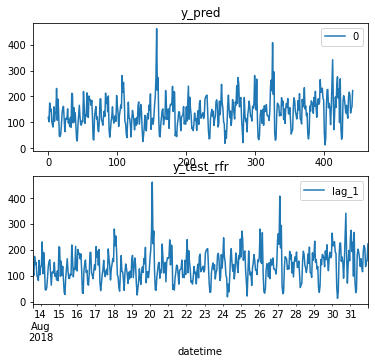

In [55]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
pd.DataFrame(y_pred1).plot(ax=plt.gca())
plt.title('y_pred')
plt.subplot(312)
pd.DataFrame(y_test_lr).plot(ax=plt.gca()) 
plt.title('y_test_rfr')

Значение метрики нас более чем устраивает (<48). С помощью графиков действительно можно увидеть высокую точность предсказаний.

## <a id='toc5_'></a> 5. Вывод[&#8593;](#toc0_)

Мы получили данные временного ряда со значениями количества заказов в такси.

Был проведен ресемплинг данных кратно часам для совершения последующего предсказания количества заказов соответственно на час вперед.

В ходе анализа мы увидели, что тренд количества заказов является восходящим, а сезонность имеет период= 1 сутки, что закономерно. Ряд является относительно стационарным (значение среднего отклонения все-таки меняется в зависимости от даты, но не критично).

Были обучены 3 модели с подбором различных гиперпараметров. Лучшей моделью является LinearRegression, которая показала метрику RMSE = 4.510374610787291e-13 << 48 на тестовых данных.
